## Searching & Downloading Sentinel-2 image

In [62]:
from pathlib import Path
import pathlib
import re
import os 
import json  
import geopandas as gpd   
from datetime import date      # standard library packages

import requests 
from tqdm import tqdm 
import sentinelsat 
import contextily as ctx
# pip install https://github.com/matplotlib/basemap/archive/master.zip
from mpl_toolkits.basemap import Basemap
from shapely.geometry import box 
import matplotlib.pyplot as plt    # third-party packages

**Required Inputs**
- AOI shp 
- SentinelSat Password & Username
- Creodias Password & Username

In [64]:
# Import the data

AOI = gpd.read_file('/ncr2420/ANSU/6_Tasks/2109_OSIP_Testing/Caribbean/AOI.shp')

# UserName and Password for SentinelSat API
api_Sentinel = sentinelsat.SentinelAPI("sulova327", "sulova327",'https://apihub.copernicus.eu/apihub')

# registration on CREODIAS: https://creodias.eu/
# source: https://creodias.eu/forum/-/message_boards/view_message/150362#_19_message_163445
username = 'ansu@dhigroup.com'
password = 'Sulova327'  

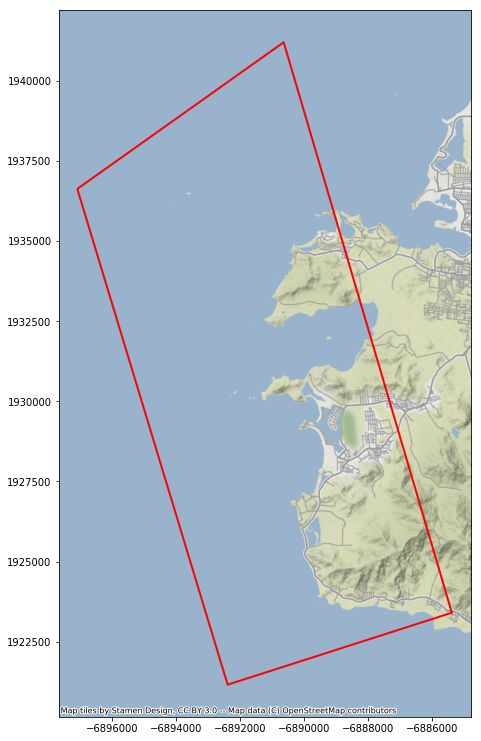

In [65]:
# Plot the AOI for a proposal
AOI_pro= AOI.to_crs(epsg = 3857)
ax_AOI = AOI_pro.plot(figsize = (9,13), facecolor = "none", lw = 2, edgecolor = 'red')
ax_AOI.plot()

# Add a basemap
ctx.add_basemap(ax_AOI,);

# Save the plot to .jpg
plt.savefig('SDB_AOI.jpg',dpi = 100)

**Identify tiles intersecting the AOI**

In [68]:
# Bound box
bounds_AOI = AOI.total_bounds
bound_box_AOI = box(*bounds_AOI)
footprint_AOI = bound_box_AOI

# Query scenes
product = api_Sentinel.query(footprint_AOI, 
                    date = (date(2015, 12, 29), 'NOW'), 
                    #platformname ='Sentinel-2', 
                    producttype = 'S2MSI1C', 
                    # area_relation ='Contains',
                    area_relation ='Intersects',
                    limit = 20 # can be changed
                            )
# Get tile
tileList = []

for value in product.values():
    tile = value['tileid']
    tileList.append(tile)
    
    
S2_Grid = gpd.read_file('/ncr2420/ANSU/3_Data/S2-Tiles/sentinel2_tiles_world.shp')
S2_Tile_Selection = S2_Grid[S2_Grid['Name'].isin(tileList)]
print('Selection of S2 Tiles:', S2_Tile_Selection.Name.values)

Selection of S2 Tiles: ['20QPD' '20QPE']


**Plot the S2 tiles box with the AOI**

/home/jovyan/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


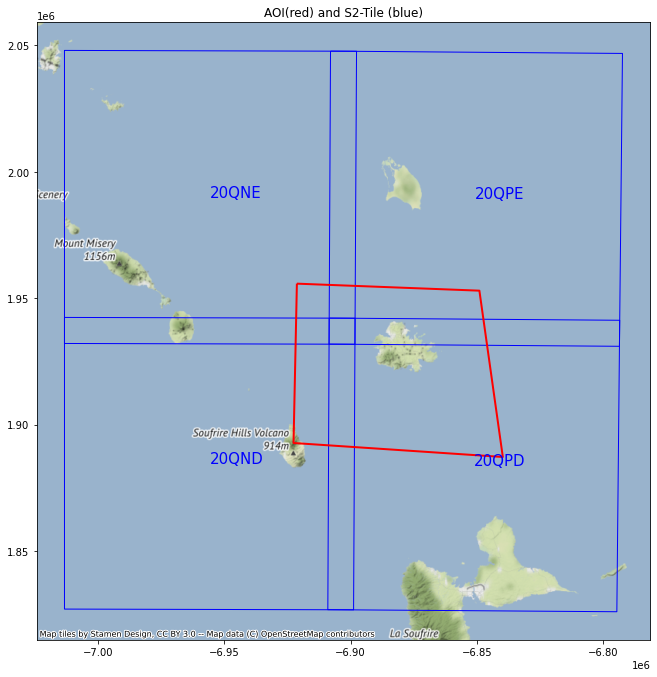

In [72]:
# WGS 84 / Pseudo-Mercator -- Spherical Mercator
S2_Tile_Selection = S2_Tile_Selection.to_crs(epsg = 3857)
AOI = AOI.to_crs(epsg = 3857)

# Plot files
S2_Tile_Plot = S2_Tile_Selection.plot(figsize = (11,16), facecolor="none", 
                                      edgecolor = 'blue', lw = 1, legend = True,
                                      legend_kwds = {'bbox_to_anchor':(0, 1.05),'fontsize':10,})

ax = AOI.plot(ax = S2_Tile_Plot, facecolor = "none", lw = 2, edgecolor = 'red',legend = True, legend_kwds = {'bbox_to_anchor':(2, 1.05),'fontsize':15,})


for i, geo in S2_Tile_Selection.centroid.iteritems():
    ax.annotate(s=S2_Tile_Selection.Name[i], xy = [geo.x, geo.y], color="blue",fontsize = 15,)
   
# Add a title to the map
ax.set(title = "AOI(red) and S2-Tile (blue)")

# Add a basemap
ctx.add_basemap(ax);

# Save the plot to .jpg
plt.savefig('SDB_AOI_S2.jpg',dpi = 100)

**Adjust Selected Tiles if needed**

In [69]:
tile_proc = S2_Tile_Selection.Name.values
tile_proc

# Define the tiles by yourself
tile_proc = ['32VMJ','32VNJ']
tile_proc

['32VMJ', '32VNJ']

In [47]:
# S2 - Date Start Ends, Product
datestarts = ['2020525']
dateends = ['20200531']
product = 'Sentinel-1'

# Directory where to save QL & Products
rootdir = pathlib.Path("/ncr2420/ANSU/6_Tasks/2109_ShipDetection/S1/")

In [48]:
for tile in tile_proc:
    for x in range(0, 1):
        results = api_Sentinel.query(
                    platformname = product, 
                    # producttype = "MSIL1C",
                    cloudcoverpercentage = (0,30),
                    tileid = tile,
                    date = (datestarts[x], dateends[x])
                           )
        tiledir = rootdir / tile
        tiledir.mkdir(parents = True, exist_ok = True)
        for pid, data in results.items():
            url = data["link_icon"]
            r = api_Sentinel.session.get(url)
            path = tiledir / "{identifier}.jpeg".format(**data)
            path.write_bytes(r.content)

**Delete QLs if needed**

In [46]:
# summary of inquiring files
for tile in tile_proc:
    tiledir = rootdir / tile
    file_names = [print(i.stem) for i in tiledir.glob("*.jpeg")]
    print(tile,'Number of files:',len(file_names))

S2A_MSIL1C_20200530T105031_N0209_R051_T32VMJ_20200530T125407
S2B_MSIL1C_20200525T104619_N0209_R051_T32VMJ_20200525T125342
S2B_MSIL1C_20200528T105619_N0209_R094_T32VMJ_20200528T121944
32VMJ Number of files: 3
S2A_MSIL1C_20200530T105031_N0209_R051_T32VNJ_20200530T125407
S2B_MSIL1C_20200525T104619_N0209_R051_T32VNJ_20200525T125342
S2B_MSIL1C_20200529T102559_N0209_R108_T32VNJ_20200529T124255
32VNJ Number of files: 3


In [33]:
# admin console and create a new client. 
def get_keycloak_token(username, password):
    h = {
    'Content-Type': 'application/x-www-form-urlencoded'
    }
    d = {
    'client_id': 'CLOUDFERRO_PUBLIC',
    'password': password,
    'username': username,
    'grant_type': 'password'
    }
    resp = requests.post('https://auth.creodias.eu/auth/realms/dias/protocol/openid-connect/token', data=d, headers=h)
    try:
        token = json.loads(resp.content.decode('utf-8'))['access_token']
    except KeyError:
        print("Can't obtain a token (check username/password), exiting.")
        sys.exit()
    return token

In [34]:
for tile in tile_proc:
    ql_names = os.listdir(Path(rootdir,tile))
    for i in range(len(ql_names)):
        os.path.join(rootdir,tile)
        name = ql_names[i][:-5]
        print(name)
        finder_api_url = 'https://finder.creodias.eu/resto/api/collections/Sentinel2/search.json?&productIdentifier=%25'+name+'%25&dataset=ESA-DATASET'
        print(finder_api_url)
        response = requests.get(finder_api_url)
        for feature in json.loads(response.content.decode('utf-8'))['features']:
            token = get_keycloak_token(username, password)
            download_url = feature['properties']['services']['download']['url']
            download_url = download_url + '?token=' + token
            total_size = feature['properties']['services']['download']['size']
            title = feature['properties']['title']
            filename = title + '.zip'
            r = requests.get(download_url, stream=True)
            if "Content-Disposition" in r.headers.keys():
                filename = re.findall("filename=(.+)", r.headers["Content-Disposition"])[0]
            # Total size in bytes.
            total_size = int(r.headers.get('content-length', 0))
            if total_size <= 100:
                print(r.text)
                sys.exit("Please try again in few moments.")
            block_size = 1024 #1 Kibibyte
            print('downloading:', filename)
            t = tqdm(total=total_size, unit='iB', unit_scale=True)
            with open(os.path.join(rootdir,tile,filename), 'wb') as f:
                print(os.path.join(rootdir,tile,filename))
                for data in r.iter_content(block_size):
                    t.update(len(data))
                    f.write(data)
            t.close()
            if total_size != 0 and t.n != total_size:
                print("ERROR, something went wrong")

S2A_MSIL1C_20200530T105031_N0209_R051_T32VMJ_20200530T125407
https://finder.creodias.eu/resto/api/collections/Sentinel2/search.json?&productIdentifier=%25S2A_MSIL1C_20200530T105031_N0209_R051_T32VMJ_20200530T125407%25&dataset=ESA-DATASET


  0%|          | 1.02k/636M [00:00<19:42:31, 8.96kiB/s]

downloading: S2A_MSIL1C_20200530T105031_N0209_R051_T32VMJ_20200530T125407.zip
/ncr2420/ANSU/6_Tasks/2109_ShipDetection/32VMJ/S2A_MSIL1C_20200530T105031_N0209_R051_T32VMJ_20200530T125407.zip


 11%|█▏        | 72.5M/636M [01:46<19:32, 481kiB/s]

KeyboardInterrupt: 